# Arithmetic Experiments

## Imports

In [1]:
from os.path import dirname, abspath
import sys, os
d = dirname(os.path.abspath(''))
sys.path.append(d)

from implicitdl import ImplicitModel, ImplicitFunctionInf, ImplicitFunctionTriu

import torch
from torch import nn
import torch.nn.functional as F
device = torch.device('cuda')
print('using ' + str(device))
torch.set_default_device(device)

import numpy as np
from tqdm.auto import trange, tqdm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# seed = 1234
# np.random.seed(seed)
# torch.manual_seed(seed)
# if torch.cuda.is_available():
#     torch.cuda.manual_seed_all(seed)
    
%matplotlib inline

using cuda


/home/ubuntu/miniconda3/envs/sim/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data Generation

In [2]:
DIM = 4
SAMPLES = 10000

randrange = lambda dim: sorted(np.random.choice(range(dim+1), size=2, replace=False))

funcs = {
    'add': lambda a, b: a+b,
    'sub': lambda a, b: a-b,
    'mul': lambda a, b: 0.5*a*b,
    'div': lambda a, b: a/b,
    'custom_1': lambda a, b: a + a*b - 2*b,
    'custom_2': lambda a, b: a**3 - 3*b**2 + a**2*b,
}

# n, m = randrange(DIM)
# p, q = randrange(DIM)
n, m = 0, DIM//2
p, q = DIM//2, DIM

def make_data(lower, upper, func):
    X = torch.tensor(np.random.uniform(lower, upper, size=(SAMPLES, DIM)), device=device, dtype=torch.float)
    a = X[:, n:m].sum(axis=-1).unsqueeze(-1)
    b = X[:, p:q].sum(axis=-1).unsqueeze(-1)
    y = func(a, b)
    return X, y

# def make_data(lower, upper, func):
#     X = torch.tensor(np.random.uniform(lower, upper, size=(SAMPLES, DIM)), device=device, dtype=torch.float)
#     y = torch.sum(X, -1)
#     return X, y.unsqueeze(-1)

## Training Code

In [3]:
def train(model, X, y, epochs, lr):
    [nn.init.kaiming_uniform_(p, mode='fan_in', nonlinearity='relu') for p in model.parameters()]
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.995)
    losses = []
    
    model.train()
    for _ in range(epochs):
        pred = model(X)
        loss = F.mse_loss(pred, y)
        l1_lambda = 0.0
        l1_norm = sum(torch.linalg.norm(p, 1) for p in model.parameters())
        loss = loss + l1_lambda * l1_norm
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

        losses.append(loss.item())
        # it.set_postfix(lr=scheduler.get_last_lr()[0])
            
    return losses

## Model Generation
To override the default nonlinearity (ReLU), override the implicit function you wish to use, and replace the phi and dphi (gradient of nonlinearity) methods.

In [4]:
class CustomInf(ImplicitFunctionInf):
    """
    Change the default convergence parameters.
    """
    mitr = grad_mitr = 500
    tol = grad_tol = 1e-6

class ImplicitFunctionInfSiLU(CustomInf):
    """
    An implicit function that uses the SiLU nonlinearity.
    """
    # triu = False
    @staticmethod
    def phi(X):
        return X * torch.sigmoid(X)

    @staticmethod
    def dphi(X):
        grad = X.clone().detach()
        sigmoid = torch.sigmoid(grad)
        return sigmoid * (1 + grad * (1 - sigmoid))
    
class ImplicitFunctionTriuSiLU(ImplicitFunctionTriu):
    """
    An implicit function that uses the SiLU nonlinearity.
    """
    mitr = grad_mitr = 500
    tol = grad_tol = 1e-6
    # triu = True
    @staticmethod
    def phi(X):
        return X * torch.sigmoid(X)

    @staticmethod
    def dphi(X):
        grad = X.clone().detach()
        sigmoid = torch.sigmoid(grad)
        return sigmoid * (1 + grad * (1 - sigmoid))
    
def fuse_parameters(model):
    """Move model parameters to a contiguous tensor, and return that tensor."""
    n = sum(p.numel() for p in model.parameters())
    params = torch.zeros(n)
    i = 0
    for p in model.parameters():
        params_slice = params[i:i + p.numel()]
        params_slice.copy_(p.flatten())
        p.data = params_slice.view(p.shape)
        i += p.numel()
    return params

def compute_accuracy(y_pred, y_true):
    close = (torch.abs(y_pred - y_true)/torch.abs(y_true) < 1e-2).float()
    return close.mean()

In [5]:
input_size = DIM
hidden_size = 3
output_size = 1

make_imp_relu = lambda: ImplicitModel(hidden_size, input_size, output_size, f=CustomInf, no_D=True)
make_imp_triu_l = lambda: ImplicitModel(hidden_size+1, input_size, output_size, f=ImplicitFunctionTriu, no_D=True)
make_imp_triu_s = lambda: ImplicitModel(hidden_size, input_size, output_size, f=ImplicitFunctionTriu, no_D=True)
make_imp_silu = lambda: ImplicitModel(hidden_size, input_size, output_size, f=ImplicitFunctionInfSiLU, no_D=True)
make_imp_triu_silu_l = lambda: ImplicitModel(hidden_size+1, input_size, output_size, f=ImplicitFunctionTriuSiLU, no_D=True)
make_imp_triu_silu_s = lambda: ImplicitModel(hidden_size, input_size, output_size, f=ImplicitFunctionTriuSiLU, no_D=True)

In [6]:
def make_mlp(act):
    return nn.Sequential(
        nn.Linear(DIM, hidden_size, bias=False),
        act(),
        nn.Linear(hidden_size, hidden_size, bias=False),
        act(),
        # nn.Linear(hidden_size, hidden_size, bias=False),
        # act(),
        nn.Linear(hidden_size, 1, bias=False),
    )

## Full Pipeline

In [7]:
EPOCHS = 1000
LR = 0.08

In [8]:
task = "add"
# task = "sub"
# task = "mul"
# task = "custom_1"
# task = "custom_2"
X, y = make_data(-1, 1, funcs[task])

models = {
    # 'ImplicitTriu_L': make_imp_triu_l().to(device),
    # 'ImplicitTriu_S': make_imp_triu_s().to(device),
    'ImplicitTriuSiLU_L': make_imp_triu_silu_l().to(device),
    'ImplicitTriuSiLU_S': make_imp_triu_silu_s().to(device),
    # 'Implicit': make_imp_relu().to(device),    
    'ImplicitSiLU': make_imp_silu().to(device),
    # 'MLP': make_mlp(nn.SiLU).to(device),
    'MLPSiLU': make_mlp(nn.SiLU).to(device)
}

print('Model Sizes:')
for name, model in models.items():
    if name == 'ImplicitTriuSiLU_L' or name == "ImplicitTriuSiLU_S":
    # if model.triu == True:
        print(name)
        size = model.A.detach().cpu().numpy().size
        non_learnable = int(size/2 - model.A.shape[0]/2)
        print(f'{name}: {sum(p.numel() for p in model.parameters()) - non_learnable} parameters')
    else:
        print(f'{name}: {sum(p.numel() for p in model.parameters())} parameters')
    # [nn.init.constant_(p, -0.01) for p in model.parameters()]


Model Sizes:
ImplicitTriuSiLU_L
ImplicitTriuSiLU_L: 30 parameters
ImplicitTriuSiLU_S
ImplicitTriuSiLU_S: 21 parameters
ImplicitSiLU: 24 parameters
MLPSiLU: 24 parameters


In [9]:
losses = {}
extraps_acc = {name: -1 for name in models}
print('\nTraining:')
for name, model in models.items():
    print(name)
    for i in range(50):
        losses[name] = train(model, X, y, EPOCHS, LR)
        X_test, y_test = make_data(-3, 3, funcs[task])
        acc = compute_accuracy(model(X_test), y_test).item()
        if acc > extraps_acc[name]:
            print("got better model", name, "with acc", acc)
            extraps_acc[name] = acc
            torch.save(model.state_dict(), f'{name}_{task}.pt')


Training:
ImplicitTriuSiLU_L


got better model ImplicitTriuSiLU_L with acc 0.16329999268054962
got better model ImplicitTriuSiLU_L with acc 0.648099958896637
got better model ImplicitTriuSiLU_L with acc 0.7198999524116516
ImplicitTriuSiLU_S
got better model ImplicitTriuSiLU_S with acc 0.021900000050663948
got better model ImplicitTriuSiLU_S with acc 0.1891999989748001
got better model ImplicitTriuSiLU_S with acc 0.5774999856948853
got better model ImplicitTriuSiLU_S with acc 0.7045999765396118
got better model ImplicitTriuSiLU_S with acc 0.8370999693870544
got better model ImplicitTriuSiLU_S with acc 0.8473999500274658
got better model ImplicitTriuSiLU_S with acc 0.9120999574661255
ImplicitSiLU
got better model ImplicitSiLU with acc 0.1314999908208847


/home/ubuntu/khai.nx/implicit-deep-learning/implicitdl/implicit_function.py:19: ImplicitFunctionWarning: Picard iterations did not converge: err=1.1921e-06, status=max itrs reached
  warnings.warn(f"Picard iterations did not converge: err={err.item():.4e}, status={status}", ImplicitFunctionWarning)
/home/ubuntu/khai.nx/implicit-deep-learning/implicitdl/implicit_function.py:19: ImplicitFunctionWarning: Picard iterations did not converge: err=1.0729e-06, status=max itrs reached
  warnings.warn(f"Picard iterations did not converge: err={err.item():.4e}, status={status}", ImplicitFunctionWarning)
/home/ubuntu/khai.nx/implicit-deep-learning/implicitdl/implicit_function.py:19: ImplicitFunctionWarning: Picard iterations did not converge: err=1.3113e-06, status=max itrs reached
  warnings.warn(f"Picard iterations did not converge: err={err.item():.4e}, status={status}", ImplicitFunctionWarning)
/home/ubuntu/khai.nx/implicit-deep-learning/implicitdl/implicit_function.py:19: ImplicitFunctionWarn

got better model ImplicitSiLU with acc 0.23739999532699585


/home/ubuntu/khai.nx/implicit-deep-learning/implicitdl/implicit_function.py:19: ImplicitFunctionWarning: Picard iterations did not converge: err=3.9368e-02, status=max itrs reached
  warnings.warn(f"Picard iterations did not converge: err={err.item():.4e}, status={status}", ImplicitFunctionWarning)
/home/ubuntu/khai.nx/implicit-deep-learning/implicitdl/implicit_function.py:32: ImplicitFunctionWarning: Gradient iterations did not converge: err=1.2070e+06, status=max itrs reached
  warnings.warn(f"Gradient iterations did not converge: err={err.item():.4e}, status={status}", ImplicitFunctionWarning)
/home/ubuntu/khai.nx/implicit-deep-learning/implicitdl/implicit_function.py:19: ImplicitFunctionWarning: Picard iterations did not converge: err=2.1458e-06, status=max itrs reached
  warnings.warn(f"Picard iterations did not converge: err={err.item():.4e}, status={status}", ImplicitFunctionWarning)
/home/ubuntu/khai.nx/implicit-deep-learning/implicitdl/implicit_function.py:19: ImplicitFunction

got better model ImplicitSiLU with acc 0.3464999794960022


/home/ubuntu/khai.nx/implicit-deep-learning/implicitdl/implicit_function.py:19: ImplicitFunctionWarning: Picard iterations did not converge: err=5.0068e-06, status=max itrs reached
  warnings.warn(f"Picard iterations did not converge: err={err.item():.4e}, status={status}", ImplicitFunctionWarning)
/home/ubuntu/khai.nx/implicit-deep-learning/implicitdl/implicit_function.py:19: ImplicitFunctionWarning: Picard iterations did not converge: err=4.2915e-06, status=max itrs reached
  warnings.warn(f"Picard iterations did not converge: err={err.item():.4e}, status={status}", ImplicitFunctionWarning)
/home/ubuntu/khai.nx/implicit-deep-learning/implicitdl/implicit_function.py:19: ImplicitFunctionWarning: Picard iterations did not converge: err=4.7684e-06, status=max itrs reached
  warnings.warn(f"Picard iterations did not converge: err={err.item():.4e}, status={status}", ImplicitFunctionWarning)
/home/ubuntu/khai.nx/implicit-deep-learning/implicitdl/implicit_function.py:19: ImplicitFunctionWarn

got better model ImplicitSiLU with acc 0.3861999809741974


/home/ubuntu/khai.nx/implicit-deep-learning/implicitdl/implicit_function.py:19: ImplicitFunctionWarning: Picard iterations did not converge: err=3.2187e-06, status=max itrs reached
  warnings.warn(f"Picard iterations did not converge: err={err.item():.4e}, status={status}", ImplicitFunctionWarning)
/home/ubuntu/khai.nx/implicit-deep-learning/implicitdl/implicit_function.py:19: ImplicitFunctionWarning: Picard iterations did not converge: err=4.0531e-06, status=max itrs reached
  warnings.warn(f"Picard iterations did not converge: err={err.item():.4e}, status={status}", ImplicitFunctionWarning)
/home/ubuntu/khai.nx/implicit-deep-learning/implicitdl/implicit_function.py:19: ImplicitFunctionWarning: Picard iterations did not converge: err=5.2452e-06, status=max itrs reached
  warnings.warn(f"Picard iterations did not converge: err={err.item():.4e}, status={status}", ImplicitFunctionWarning)
/home/ubuntu/khai.nx/implicit-deep-learning/implicitdl/implicit_function.py:19: ImplicitFunctionWarn

got better model ImplicitSiLU with acc 0.9546999931335449


/home/ubuntu/khai.nx/implicit-deep-learning/implicitdl/implicit_function.py:19: ImplicitFunctionWarning: Picard iterations did not converge: err=3.6955e-06, status=max itrs reached
  warnings.warn(f"Picard iterations did not converge: err={err.item():.4e}, status={status}", ImplicitFunctionWarning)
/home/ubuntu/khai.nx/implicit-deep-learning/implicitdl/implicit_function.py:19: ImplicitFunctionWarning: Picard iterations did not converge: err=4.6492e-06, status=max itrs reached
  warnings.warn(f"Picard iterations did not converge: err={err.item():.4e}, status={status}", ImplicitFunctionWarning)
/home/ubuntu/khai.nx/implicit-deep-learning/implicitdl/implicit_function.py:19: ImplicitFunctionWarning: Picard iterations did not converge: err=3.6359e-06, status=max itrs reached
  warnings.warn(f"Picard iterations did not converge: err={err.item():.4e}, status={status}", ImplicitFunctionWarning)
/home/ubuntu/khai.nx/implicit-deep-learning/implicitdl/implicit_function.py:19: ImplicitFunctionWarn

MLPSiLU
got better model MLPSiLU with acc 0.19200000166893005
got better model MLPSiLU with acc 0.20589999854564667
got better model MLPSiLU with acc 0.3082999885082245
got better model MLPSiLU with acc 0.3718999922275543
got better model MLPSiLU with acc 0.4737999737262726
got better model MLPSiLU with acc 0.558899998664856
got better model MLPSiLU with acc 0.6335999965667725
got better model MLPSiLU with acc 0.6791999936103821
got better model MLPSiLU with acc 0.8788999915122986


In [10]:
print('\nExtrapolation')
# factors = np.logspace(0, 2, num=10)
factors = np.linspace(1, 10, num=10)
# factors = [1, 2, 4, 8]
# factors = [2, 2]
extraps = {name: [] for name in models}
extraps_acc = {name: [] for name in models}
for factor in factors:
    X_test, y_test = make_data(-factor, factor, funcs[task])
    # X_test, y_test = X, y
    for name, model in models.items():
        model.load_state_dict(torch.load(f'{name}_{task}.pt'))
        model.to(device)
        with torch.no_grad():
            extraps[name].append(F.mse_loss(model(X_test), y_test).item())
            extraps_acc[name].append(compute_accuracy(model(X_test), y_test).item())
            
my_task = (task, losses, extraps)


Extrapolation


In [11]:
for name, model in models.items():
    print(name)
    print(" train(lasso):", losses[name][-1])
    print(" test(mse):", extraps[name][0])
    print(" acc:", extraps_acc[name][0])
    params = fuse_parameters(model)
    print(" nonzeros:", torch.count_nonzero(params).item())
    print("\n")

ImplicitTriuSiLU_L
 train(lasso): 0.004656541161239147
 test(mse): 2.2912158783583436e-06
 acc: 0.9412999749183655
 nonzeros: 26


ImplicitTriuSiLU_S
 train(lasso): 0.0015932940877974033
 test(mse): 2.4160165139619494e-06
 acc: 0.9662999510765076
 nonzeros: 18


ImplicitSiLU
 train(lasso): 8.164192695403472e-05
 test(mse): 1.646947112021735e-06
 acc: 0.9822999835014343
 nonzeros: 24


MLPSiLU
 train(lasso): 0.0011575447861105204
 test(mse): 1.0873886822082568e-05
 acc: 0.8948999643325806
 nonzeros: 24




In [12]:
# idx = 6
# model = models['ImplicitTriu_L']
# print(model(X_test)[idx], y_test[idx])
# model = models['MLP']
# print(model(X_test)[idx], y_test[idx])

## Plot Results

In [13]:
styles = ['--', '-.', '-', ':', '-', '--', '-.', ':']

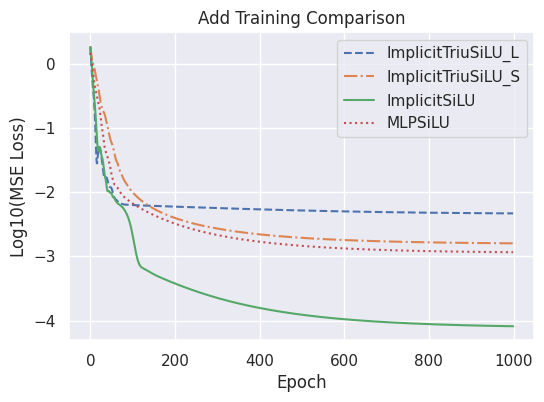

In [14]:
fig, axes = plt.subplots(1, 1, figsize=(6, 4))
plt.rcParams['axes.grid'] = True
for ax, (name, losses, _) in zip([axes], [my_task]):
    
    for style, (model_name, model_loss) in zip(styles, losses.items()):
        ax.plot(np.log10(model_loss), label=model_name, ls=style)
    
    # ax.set_ylim(-5, 2)
    ax.set_title(f'{name.title()} Training Comparison')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Log10(MSE Loss)')
    ax.legend()
    
plt.show()

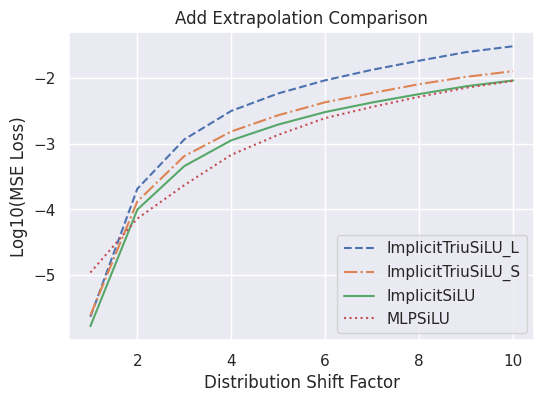

In [15]:
fig, axes = plt.subplots(1, 1, figsize=(6, 4))

for ax, (name, _, extraps) in zip([axes], [my_task]):
    
    for style, (model_name, model_extrap) in zip(styles, extraps.items()):
        ax.plot(factors, np.log10(model_extrap), label=model_name, ls=style)
        # ax.plot(np.log10(factors), np.log10(model_extrap), label=model_name, ls=style)
    
    # ax.set_ylim(-5, 10)
    ax.set_title(f'{name.title()} Extrapolation Comparison')
    ax.set_xlabel('Distribution Shift Factor')
    ax.set_ylabel('Log10(MSE Loss)')
    ax.legend()
    
plt.show()

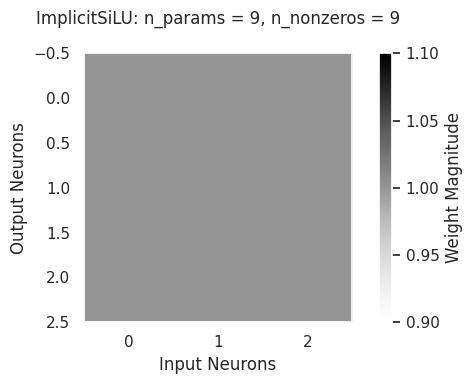

In [16]:
import matplotlib.pyplot as plt
import scipy.sparse as sp

model_name = 'ImplicitSiLU'
# model_name = 'ImplicitTriuSiLU_L'
# model_name = 'ImplicitTriuSiLU_S'
vis_model = models[model_name].to('cpu')
plt.rcParams['axes.grid'] = False
plt.figure(figsize=(6, 4))
matrix = np.abs(vis_model.A.detach().numpy())
# print(matrix)
non_zero_weights = np.isclose(matrix, 0, 1e-5) == False
im = plt.imshow(non_zero_weights, cmap='Greys', aspect='equal')
plt.title(f'{model_name}: n_params = {matrix.size}, n_nonzeros = {np.count_nonzero(non_zero_weights)}\n')
plt.xlabel('Input Neurons')
plt.ylabel('Output Neurons')

cbar = plt.colorbar(im)
cbar.set_label('Weight Magnitude')

plt.tight_layout()
plt.show()

how to evaluate sparsity:
- absolute number of nonzeros
- percentage of nonzeros

robustness
- enable some random lower triangular elements, increase 10% number of parameters, add L1 norm (encourage sparsity, reduce 10% number of nonzeros) and hope for better performance and robustness